<a href="https://colab.research.google.com/github/DiegoSamanezDenis/COMP472-Brain-Tumor-MRI-CNN/blob/main/notebooks/15c_Classification_MRI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
from google.colab import files
import os

files.upload()

!mkdir -p ~/.kaggle/
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d fernando2rad/brain-tumor-mri-images-44c

!unzip -q brain-tumor-mri-images-44c.zip -d dataset_44c


Saving kaggle.json to kaggle (2).json
Dataset URL: https://www.kaggle.com/datasets/fernando2rad/brain-tumor-mri-images-44c
License(s): Community Data License Agreement - Sharing - Version 1.0
brain-tumor-mri-images-44c.zip: Skipping, found more recently modified local copy (use --force to force download)
replace dataset_44c/Astrocitoma T1/005_big_gallery.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [32]:
import torch
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split

In [33]:
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [34]:
def get_stratified_splits(dataset, val_split=0.15, test_split=0.15):
  targets = dataset.targets

  train_idx, temp_idx = train_test_split(
    np.arange(len(targets)),
    test_size=(val_split + test_split),
    stratify = targets,
    random_state=42
  )

  temp_targets = [targets[i] for i in temp_idx]

  val_idx, test_idx = train_test_split(
      temp_idx,
      test_size=0.5,
      stratify = temp_targets,
      random_state=42
  )

  return Subset(dataset, train_idx), Subset(dataset, val_idx), Subset(dataset, test_idx)

In [35]:
ds_44c = datasets.ImageFolder('dataset_44c', transform=data_transforms)
train_44c, val_44c, test_44c=get_stratified_splits(ds_44c)

In [36]:
train_loader_44c=DataLoader(train_44c, batch_size=32, shuffle=True)
val_loader_44c=DataLoader(val_44c, batch_size=32, shuffle=False)
test_loader_44c=DataLoader(test_44c, batch_size=32, shuffle=False)

In [37]:
print(f'Total images: {len(ds_44c)}')
print(f'Train Size: {len(train_44c)}, Val Size: {len(val_44c)}, Test Size: {len(test_44c)}')

Total images: 4479
Train Size: 3135, Val Size: 672, Test Size: 672


In [38]:
NUM_CLASSES = len(ds_44c.classes)
print(f'Number of classes: {NUM_CLASSES}')

Number of classes: 44


# ResNet18

In [39]:
import torch.nn as nn
from torchvision import models
import torch.optim as optim

model = models.resnet18(weights=None)

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, NUM_CLASSES)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)

print(f'Total trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}')

Total trainable parameters: 11,199,084


# MobileNetV2

In [40]:
model_mobilenet = models.mobilenet_v2(weights=None)
model_mobilenet.classifier[1] = nn.Linear(model_mobilenet.last_channel, NUM_CLASSES)

criterion_mobilenet = nn.CrossEntropyLoss()
optimizer_mobilenet = optim.AdamW(model_mobilenet.parameters(), lr=0.001)

print(f'MobileNetV2 trainable parameters: {sum(p.numel() for p in model_mobilenet.parameters() if p.requires_grad):,}')

MobileNetV2 trainable parameters: 2,280,236


# VGG16

In [41]:
model_vgg = models.vgg16(weights=None)
model_vgg.classifier[6] = nn.Linear(4096, NUM_CLASSES)

criterion_vgg = nn.CrossEntropyLoss()
optimizer_vgg = optim.AdamW(model_vgg.parameters(), lr=0.001)

print(f'VGG16 trainable parameters: {sum(p.numel() for p in model_vgg.parameters() if p.requires_grad):,}')

VGG16 trainable parameters: 134,440,812


# Training & Evaluation Pipeline

In [56]:
import copy
import time
import json
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tqdm.notebook import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [54]:
def train_model(model, criterion, optimizer, dataloaders, device,
                num_epochs=25, save_path=None):
    """
    Train with validation, track history, save best weights.

    Args:
        dataloaders: dict with 'train' and 'val' keys
        save_path: .pth path to save best weights (also saves _history.json)
    Returns:
        model (best weights loaded), history dict
    """
    model = model.to(device)
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    since = time.time()

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 40)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in tqdm(dataloaders[phase], desc=f'  {phase}', leave=False):
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = (running_corrects.double() / len(dataloaders[phase].dataset)).item()

            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc)

            print(f'  {phase:5s} Loss: {epoch_loss:.4f}  Acc: {epoch_acc:.4f}')

            # Save best model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                if save_path:
                    torch.save(best_model_wts, save_path)
                    print(f'  ==> New best model saved to {save_path}')

        print()

    elapsed = time.time() - since
    print(f'Training complete in {elapsed // 60:.0f}m {elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')

    # Restore best weights
    model.load_state_dict(best_model_wts)

    # Save history alongside weights
    if save_path:
        history_path = save_path.replace('.pth', '_history.json')
        with open(history_path, 'w') as f:
            json.dump(history, f)
        print(f'History saved to {history_path}')

    return model, history

In [44]:
def evaluate_model(model, test_loader, class_names, device):
    """Run evaluation on test set. Returns confusion matrix, labels, preds."""
    model = model.to(device)
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print('\nClassification Report:')
    print(classification_report(all_labels, all_preds,
                                target_names=class_names, zero_division=0))

    cm = confusion_matrix(all_labels, all_preds)
    return cm, all_labels, all_preds

In [45]:
def plot_training_curves(history, title=''):
    """Plot loss and accuracy curves."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))
    epochs = range(1, len(history['train_loss']) + 1)

    ax1.plot(epochs, history['train_loss'], 'b-', label='Train')
    ax1.plot(epochs, history['val_loss'], 'r-', label='Validation')
    ax1.set_title(f'{title} — Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    ax2.plot(epochs, history['train_acc'], 'b-', label='Train')
    ax2.plot(epochs, history['val_acc'], 'r-', label='Validation')
    ax2.set_title(f'{title} — Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


def plot_confusion_matrix(cm, class_names, title=''):
    """Plot confusion matrix as a heatmap."""
    fig, ax = plt.subplots(figsize=(max(8, len(class_names) * 0.5),
                                     max(6, len(class_names) * 0.4)))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names, ax=ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title(f'{title} — Confusion Matrix')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Mount Google Drive

In [49]:
from google.colab import drive
drive.mount('/content/drive')

SAVE_DIR = '/content/drive/MyDrive/brain_tumor_weights'
os.makedirs(SAVE_DIR, exist_ok=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Build Dataloaders Dict
Wraps the existing loaders into the `{'train': ..., 'val': ...}` format expected by `train_model`.

In [51]:
dataloaders_44c = {
    'train': train_loader_44c,
    'val': val_loader_44c
}

# Train ResNet18 (Scratch) — 44c

In [ ]:
model, history_resnet = train_model(
    model, criterion, optimizer, dataloaders_44c, device,
    num_epochs=20,
    save_path=os.path.join(SAVE_DIR, 'resnet18_44c_scratch.pth')
)

In [ ]:
plot_training_curves(history_resnet, title='ResNet18 — 44c Scratch')
cm_resnet, _, _ = evaluate_model(model, test_loader_44c, ds_44c.classes, device)
plot_confusion_matrix(cm_resnet, ds_44c.classes, title='ResNet18 — 44c Scratch')

# Train MobileNetV2 (Scratch) — 44c

In [52]:
model_mobilenet, history_mobilenet = train_model(
    model_mobilenet, criterion_mobilenet, optimizer_mobilenet, dataloaders_44c, device,
    num_epochs=20,
    save_path=os.path.join(SAVE_DIR, 'mobilenetv2_44c_scratch.pth')
)

Epoch 1/20
----------------------------------------
  train Loss: 3.1034  Acc: 0.1751
  val   Loss: 3.1421  Acc: 0.2351
  ==> New best model saved to /content/drive/MyDrive/brain_tumor_weights/mobilenetv2_44c_scratch.pth

Epoch 2/20
----------------------------------------
  train Loss: 2.3633  Acc: 0.3362
  val   Loss: 2.8275  Acc: 0.2649
  ==> New best model saved to /content/drive/MyDrive/brain_tumor_weights/mobilenetv2_44c_scratch.pth

Epoch 3/20
----------------------------------------
  train Loss: 1.8780  Acc: 0.4670
  val   Loss: 2.0588  Acc: 0.4330
  ==> New best model saved to /content/drive/MyDrive/brain_tumor_weights/mobilenetv2_44c_scratch.pth

Epoch 4/20
----------------------------------------
  train Loss: 1.3844  Acc: 0.5904
  val   Loss: 1.7038  Acc: 0.5283
  ==> New best model saved to /content/drive/MyDrive/brain_tumor_weights/mobilenetv2_44c_scratch.pth

Epoch 5/20
----------------------------------------
  train Loss: 1.0780  Acc: 0.6724
  val   Loss: 1.5496  Acc:

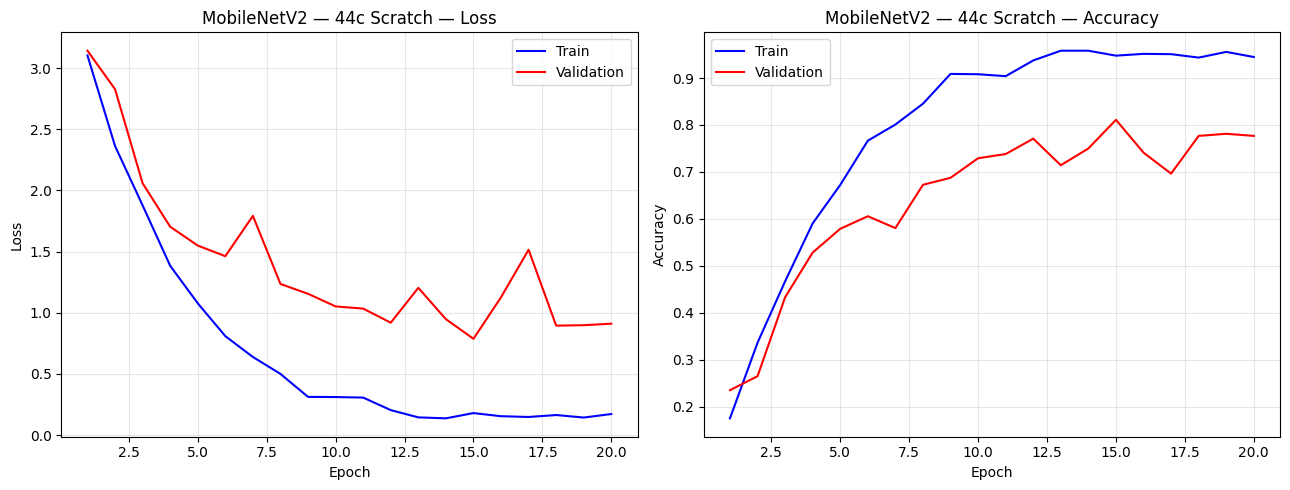


Classification Report:
                        precision    recall  f1-score   support

        Astrocitoma T1       0.80      0.77      0.78        26
      Astrocitoma T1C+       0.91      0.86      0.88        35
        Astrocitoma T2       0.94      0.65      0.77        26
          Carcinoma T1       0.90      0.90      0.90        10
        Carcinoma T1C+       0.94      0.88      0.91        17
          Carcinoma T2       1.00      1.00      1.00        11
         Ependimoma T1       0.80      0.57      0.67         7
       Ependimoma T1C+       0.75      0.86      0.80         7
         Ependimoma T2       0.64      0.88      0.74         8
      Ganglioglioma T1       0.40      0.67      0.50         3
    Ganglioglioma T1C+       1.00      0.67      0.80         3
      Ganglioglioma T2       1.00      0.33      0.50         3
          Germinoma T1       1.00      1.00      1.00         4
        Germinoma T1C+       1.00      0.67      0.80         6
          Germi

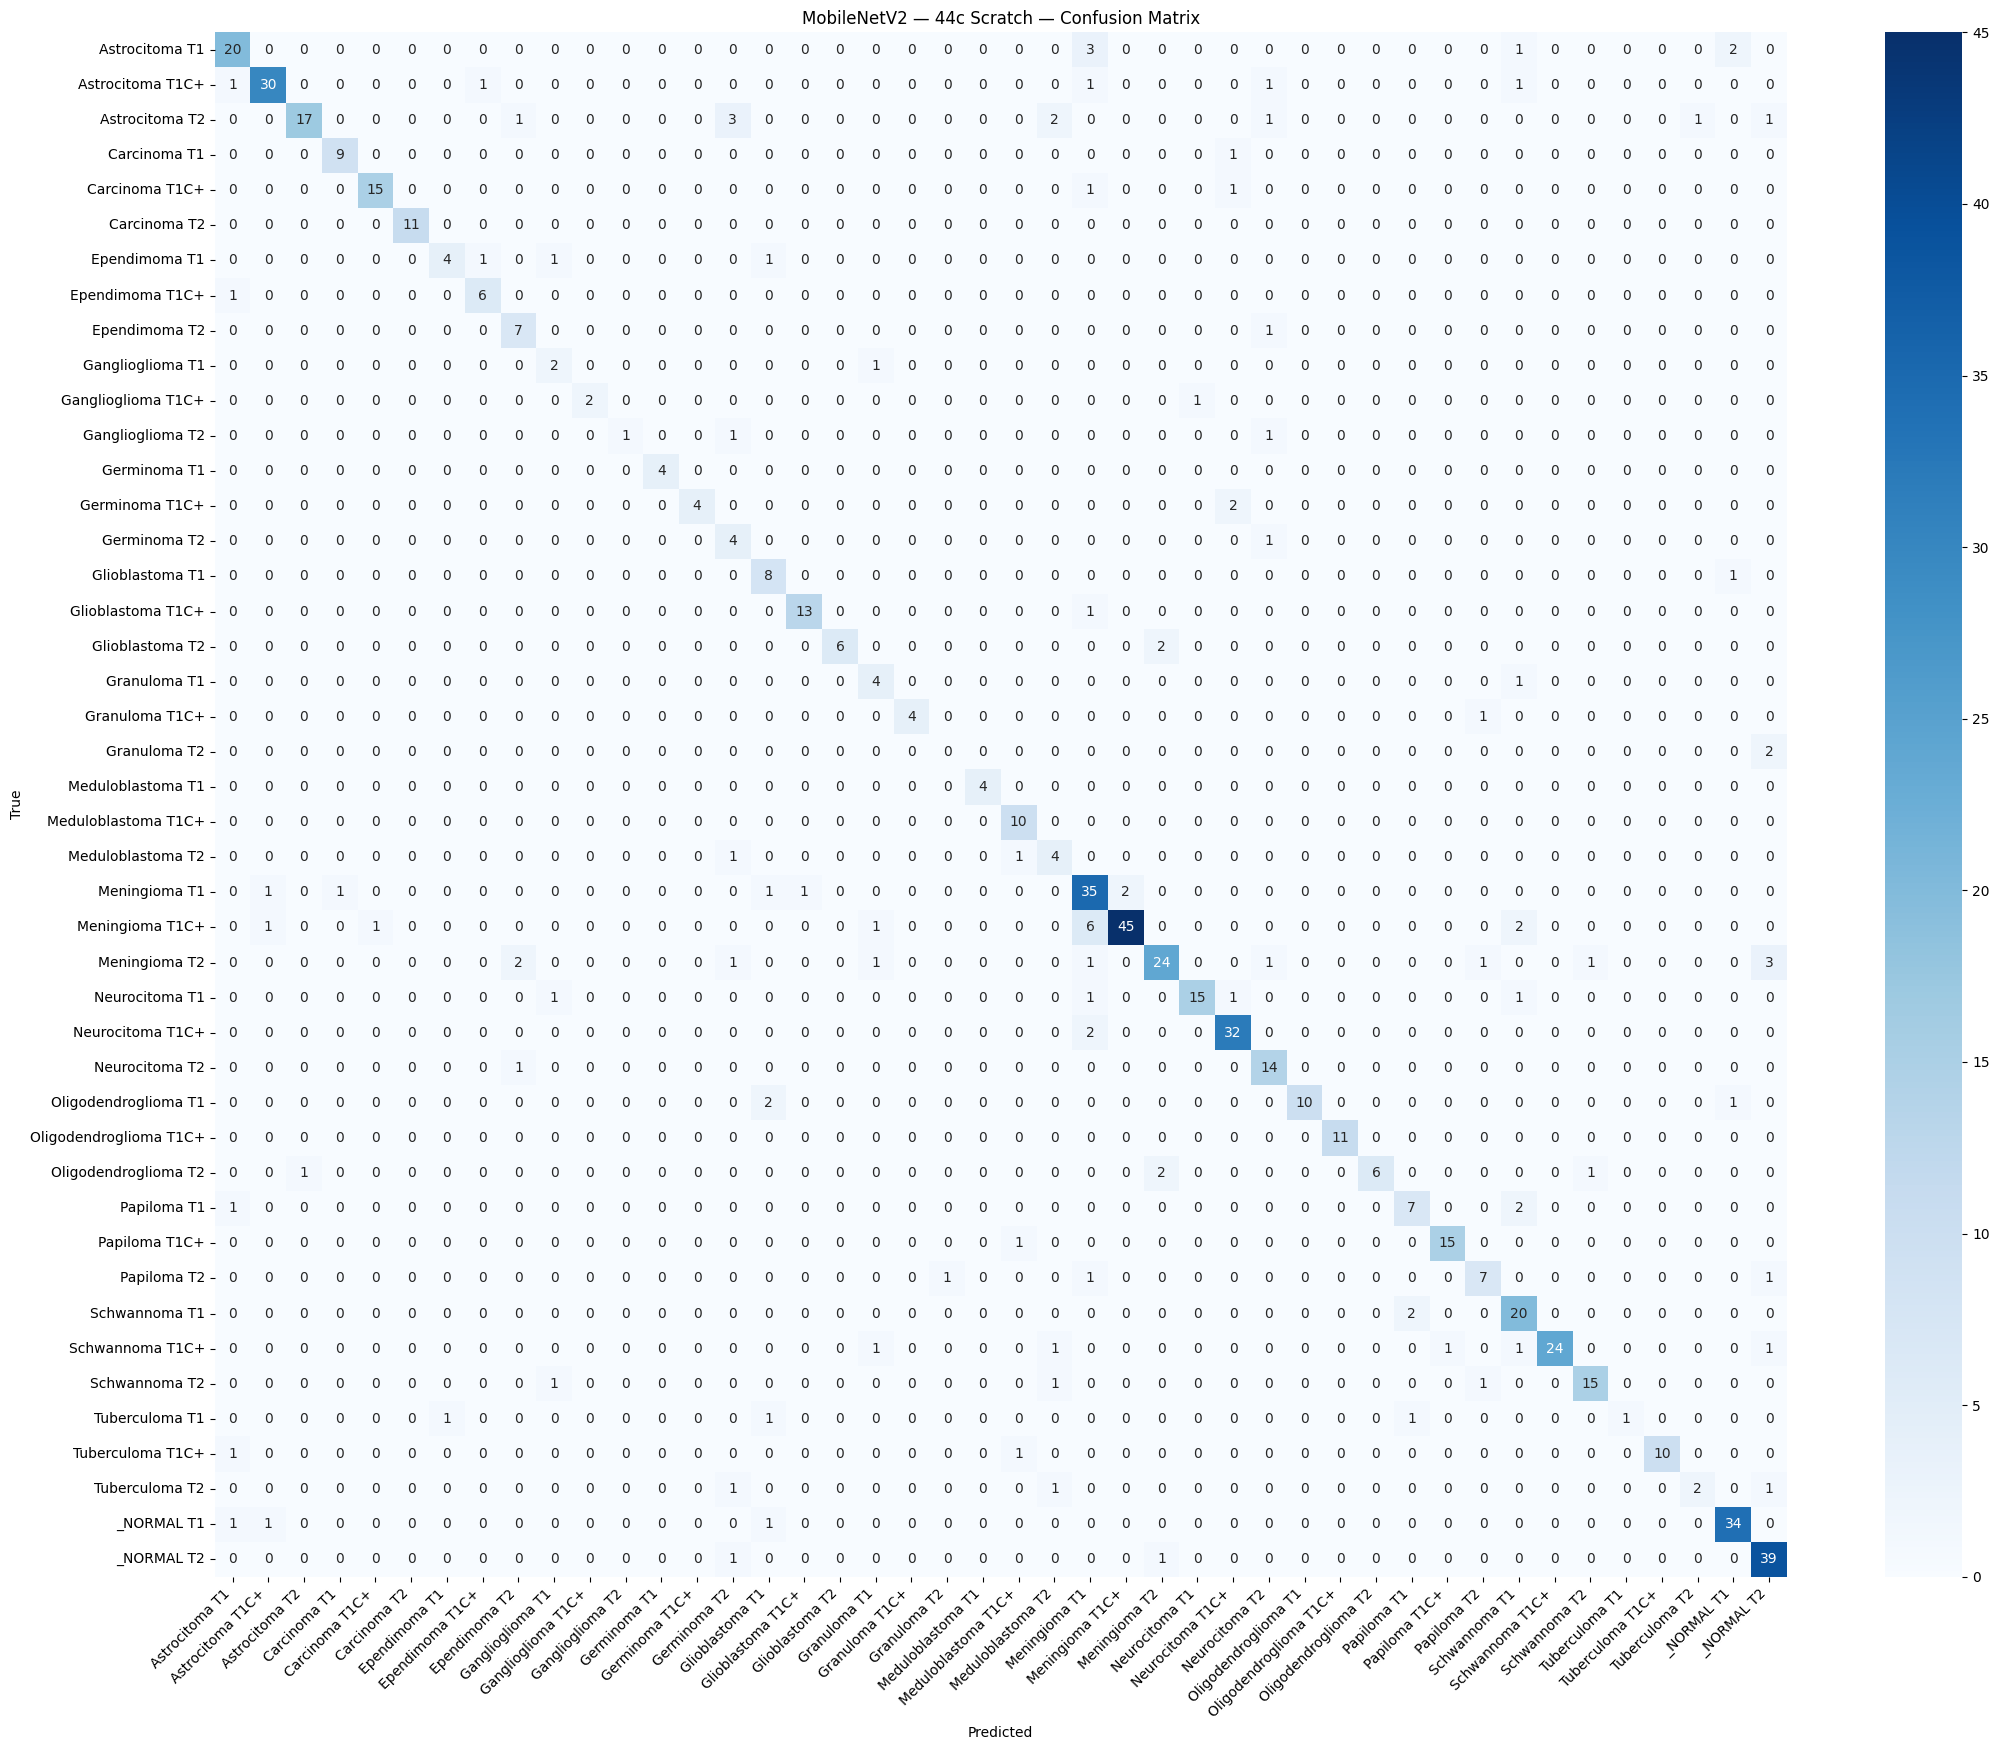

In [53]:
plot_training_curves(history_mobilenet, title='MobileNetV2 — 44c Scratch')
cm_mobilenet, _, _ = evaluate_model(model_mobilenet, test_loader_44c, ds_44c.classes, device)
plot_confusion_matrix(cm_mobilenet, ds_44c.classes, title='MobileNetV2 — 44c Scratch')

# Train VGG16 (Scratch) — 44c

In [57]:
model_vgg, history_vgg = train_model(
    model_vgg, criterion_vgg, optimizer_vgg, dataloaders_44c, device,
    num_epochs=20,
    save_path=os.path.join(SAVE_DIR, 'vgg16_44c_scratch.pth')
)

Epoch 1/20
----------------------------------------


  train:   0%|          | 0/98 [00:00<?, ?it/s]

  train Loss: 5.0182  Acc: 0.0679


  val:   0%|          | 0/21 [00:00<?, ?it/s]

  val   Loss: 3.4852  Acc: 0.0818
  ==> New best model saved to /content/drive/MyDrive/brain_tumor_weights/vgg16_44c_scratch.pth

Epoch 2/20
----------------------------------------


  train:   0%|          | 0/98 [00:00<?, ?it/s]

  train Loss: 3.5016  Acc: 0.0762


  val:   0%|          | 0/21 [00:00<?, ?it/s]

  val   Loss: 3.4874  Acc: 0.0818

Epoch 3/20
----------------------------------------


  train:   0%|          | 0/98 [00:00<?, ?it/s]

  train Loss: 3.5024  Acc: 0.0823


  val:   0%|          | 0/21 [00:00<?, ?it/s]

  val   Loss: 3.4815  Acc: 0.0818

Epoch 4/20
----------------------------------------


  train:   0%|          | 0/98 [00:00<?, ?it/s]

  train Loss: 3.4936  Acc: 0.0781


  val:   0%|          | 0/21 [00:00<?, ?it/s]

  val   Loss: 3.4821  Acc: 0.0818

Epoch 5/20
----------------------------------------


  train:   0%|          | 0/98 [00:00<?, ?it/s]

  train Loss: 3.4946  Acc: 0.0833


  val:   0%|          | 0/21 [00:00<?, ?it/s]

  val   Loss: 3.4821  Acc: 0.0818

Epoch 6/20
----------------------------------------


  train:   0%|          | 0/98 [00:00<?, ?it/s]

  train Loss: 3.4944  Acc: 0.0817


  val:   0%|          | 0/21 [00:00<?, ?it/s]

  val   Loss: 3.4814  Acc: 0.0818

Epoch 7/20
----------------------------------------


  train:   0%|          | 0/98 [00:00<?, ?it/s]

  train Loss: 3.4897  Acc: 0.0817


  val:   0%|          | 0/21 [00:00<?, ?it/s]

  val   Loss: 3.4796  Acc: 0.0818

Epoch 8/20
----------------------------------------


  train:   0%|          | 0/98 [00:00<?, ?it/s]

  train Loss: 3.4940  Acc: 0.0823


  val:   0%|          | 0/21 [00:00<?, ?it/s]

  val   Loss: 3.4830  Acc: 0.0818

Epoch 9/20
----------------------------------------


  train:   0%|          | 0/98 [00:00<?, ?it/s]

  train Loss: 3.4944  Acc: 0.0823


  val:   0%|          | 0/21 [00:00<?, ?it/s]

  val   Loss: 3.4795  Acc: 0.0818

Epoch 10/20
----------------------------------------


  train:   0%|          | 0/98 [00:00<?, ?it/s]

  train Loss: 3.4916  Acc: 0.0823


  val:   0%|          | 0/21 [00:00<?, ?it/s]

  val   Loss: 3.4813  Acc: 0.0818

Epoch 11/20
----------------------------------------


  train:   0%|          | 0/98 [00:00<?, ?it/s]

  train Loss: 3.4927  Acc: 0.0823


  val:   0%|          | 0/21 [00:00<?, ?it/s]

  val   Loss: 3.4801  Acc: 0.0818

Epoch 12/20
----------------------------------------


  train:   0%|          | 0/98 [00:00<?, ?it/s]

  train Loss: 3.4891  Acc: 0.0823


  val:   0%|          | 0/21 [00:00<?, ?it/s]

  val   Loss: 3.4785  Acc: 0.0818

Epoch 13/20
----------------------------------------


  train:   0%|          | 0/98 [00:00<?, ?it/s]

  train Loss: 3.4901  Acc: 0.0817


  val:   0%|          | 0/21 [00:00<?, ?it/s]

  val   Loss: 3.4797  Acc: 0.0818

Epoch 14/20
----------------------------------------


  train:   0%|          | 0/98 [00:00<?, ?it/s]

  train Loss: 3.4891  Acc: 0.0817


  val:   0%|          | 0/21 [00:00<?, ?it/s]

  val   Loss: 3.4792  Acc: 0.0818

Epoch 15/20
----------------------------------------


  train:   0%|          | 0/98 [00:00<?, ?it/s]

  train Loss: 3.4890  Acc: 0.0826


  val:   0%|          | 0/21 [00:00<?, ?it/s]

  val   Loss: 3.4790  Acc: 0.0818

Epoch 16/20
----------------------------------------


  train:   0%|          | 0/98 [00:00<?, ?it/s]

  train Loss: 3.4878  Acc: 0.0813


  val:   0%|          | 0/21 [00:00<?, ?it/s]

  val   Loss: 3.4804  Acc: 0.0818

Epoch 17/20
----------------------------------------


  train:   0%|          | 0/98 [00:00<?, ?it/s]

  train Loss: 3.4879  Acc: 0.0823


  val:   0%|          | 0/21 [00:00<?, ?it/s]

  val   Loss: 3.4801  Acc: 0.0818

Epoch 18/20
----------------------------------------


  train:   0%|          | 0/98 [00:00<?, ?it/s]

  train Loss: 3.4895  Acc: 0.0823


  val:   0%|          | 0/21 [00:00<?, ?it/s]

  val   Loss: 3.4786  Acc: 0.0818

Epoch 19/20
----------------------------------------


  train:   0%|          | 0/98 [00:00<?, ?it/s]

  train Loss: 3.4873  Acc: 0.0823


  val:   0%|          | 0/21 [00:00<?, ?it/s]

  val   Loss: 3.4788  Acc: 0.0818

Epoch 20/20
----------------------------------------


  train:   0%|          | 0/98 [00:00<?, ?it/s]

  train Loss: 3.4899  Acc: 0.0820


  val:   0%|          | 0/21 [00:00<?, ?it/s]

  val   Loss: 3.4799  Acc: 0.0818

Training complete in 24m 46s
Best val Acc: 0.0818
History saved to /content/drive/MyDrive/brain_tumor_weights/vgg16_44c_scratch_history.json


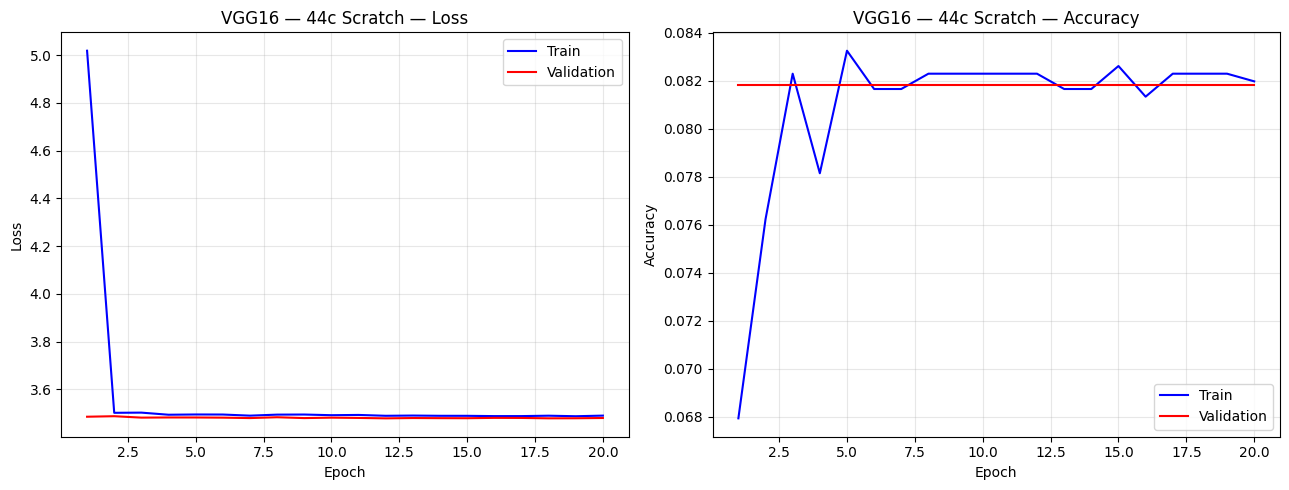


Classification Report:
                        precision    recall  f1-score   support

        Astrocitoma T1       0.00      0.00      0.00        26
      Astrocitoma T1C+       0.00      0.00      0.00        35
        Astrocitoma T2       0.00      0.00      0.00        26
          Carcinoma T1       0.00      0.00      0.00        10
        Carcinoma T1C+       0.00      0.00      0.00        17
          Carcinoma T2       0.00      0.00      0.00        11
         Ependimoma T1       0.00      0.00      0.00         7
       Ependimoma T1C+       0.00      0.00      0.00         7
         Ependimoma T2       0.00      0.00      0.00         8
      Ganglioglioma T1       0.00      0.00      0.00         3
    Ganglioglioma T1C+       0.00      0.00      0.00         3
      Ganglioglioma T2       0.00      0.00      0.00         3
          Germinoma T1       0.00      0.00      0.00         4
        Germinoma T1C+       0.00      0.00      0.00         6
          Germi

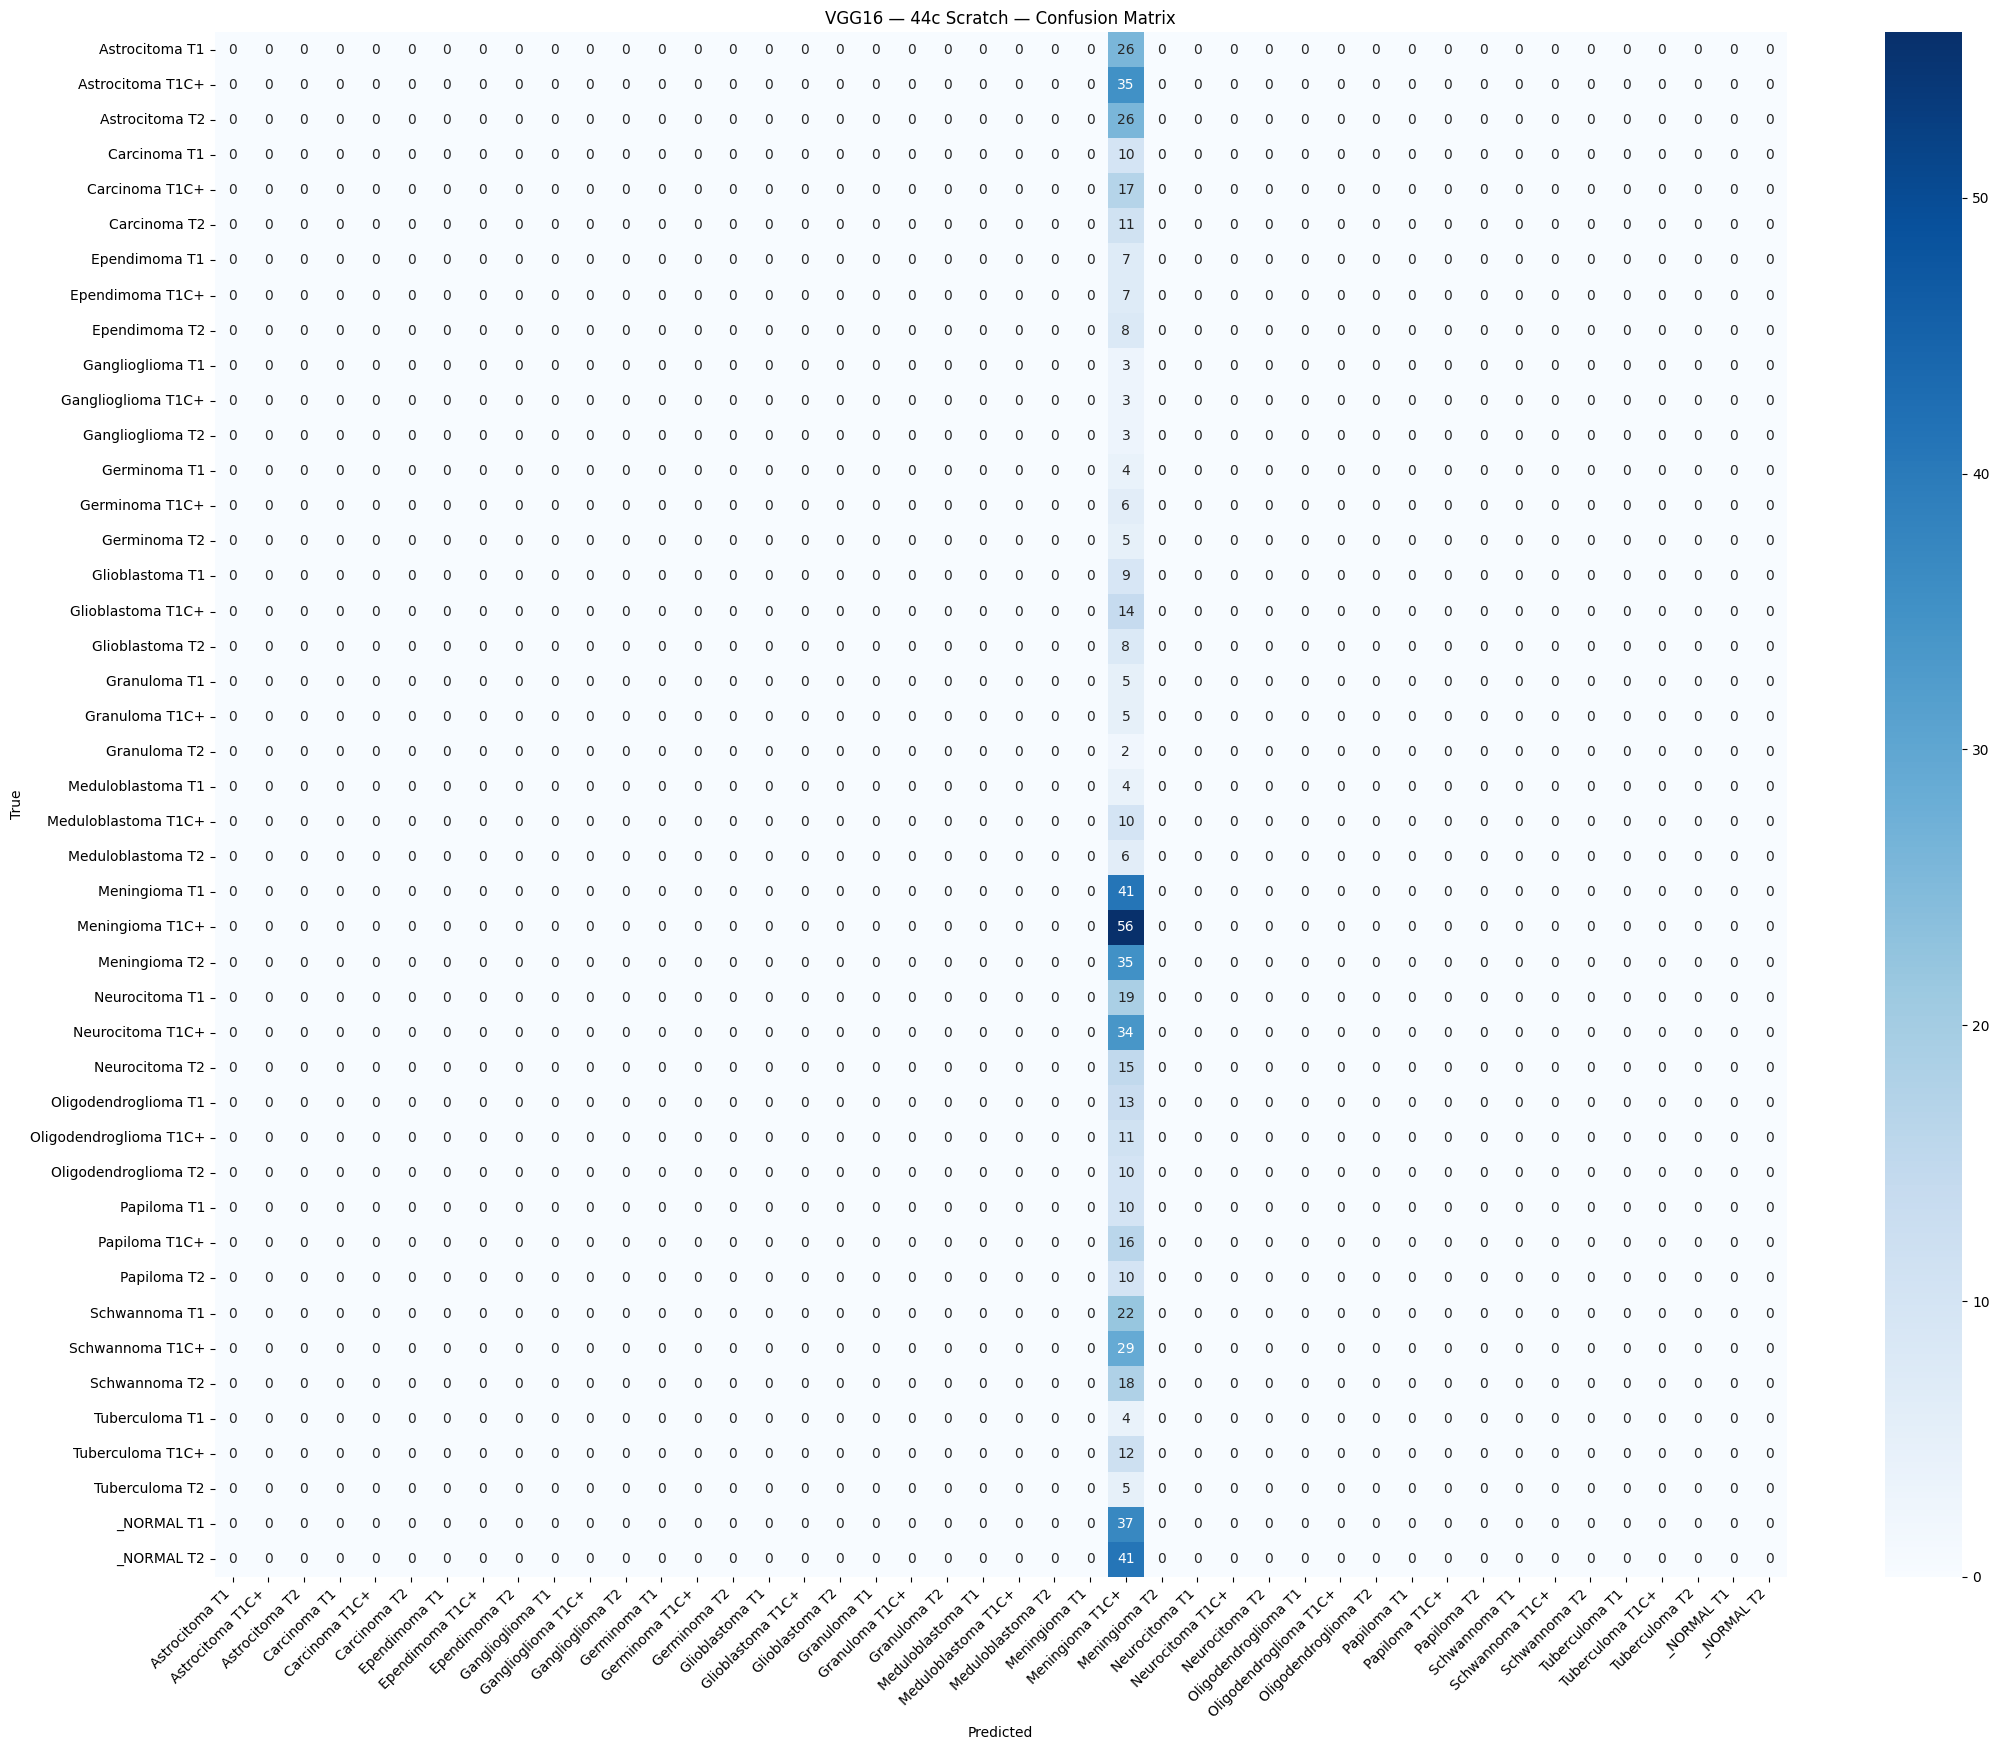

In [58]:
plot_training_curves(history_vgg, title='VGG16 — 44c Scratch')
cm_vgg, _, _ = evaluate_model(model_vgg, test_loader_44c, ds_44c.classes, device)
plot_confusion_matrix(cm_vgg, ds_44c.classes, title='VGG16 — 44c Scratch')

# Reload Saved Model & History (Example)
Use this to reload weights after a runtime restart without retraining.

In [ ]:
# # Example: reload ResNet18 scratch weights
# model_reloaded = models.resnet18(weights=None)
# model_reloaded.fc = nn.Linear(model_reloaded.fc.in_features, NUM_CLASSES)
# model_reloaded.load_state_dict(torch.load(os.path.join(SAVE_DIR, 'resnet18_44c_scratch.pth')))
# model_reloaded.to(device).eval()

# # Reload history for plotting
# with open(os.path.join(SAVE_DIR, 'resnet18_44c_scratch_history.json')) as f:
#     history_reloaded = json.load(f)
# plot_training_curves(history_reloaded, title='ResNet18 — 44c Scratch (reloaded)')